In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import genextreme, genpareto

In [2]:
# 1. Membaca data dari file Excel
file_path = "Data Curah Hujan Harian 2022-2024 Cleaned.xlsx"  # Ganti dengan path file data
data = pd.read_excel(file_path, header=0)

# 2. Menetapkan nama kolom secara manual jika kolom 'Tanggal' tidak ditemukan
data.columns = ['Tanggal', 'Curah Hujan', 'Kolom_Tidak_Terpakai', 'Keterangan']  # Sesuaikan dengan kolom di data

# 3. Menghapus kolom yang tidak relevan
data = data.drop(columns=['Kolom_Tidak_Terpakai', 'Keterangan'])

In [3]:
# 4. Mengonversi 'Curah Hujan' menjadi numerik
data['Curah Hujan'] = pd.to_numeric(data['Curah Hujan'], errors='coerce')

# 5. Mengonversi 'Tanggal' menjadi format datetime
data['Tanggal'] = pd.to_datetime(data['Tanggal'], errors='coerce')

# 6. Menghapus baris dengan nilai curah hujan atau tanggal kosong
data.dropna(subset=['Curah Hujan', 'Tanggal'], inplace=True)

C:\Users\muham\AppData\Local\Temp\ipykernel_14932\3801381582.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Tanggal'] = pd.to_datetime(data['Tanggal'], errors='coerce')


In [4]:
# 7. Menambahkan kolom 'Bulan' yang terdiri dari Tahun dan Bulan
data['Bulan'] = data['Tanggal'].dt.to_period('M')

# 8. Mengelompokkan berdasarkan bulan dan mencari nilai maksimum dari curah hujan per bulan
bulan_max = data.groupby('Bulan')['Curah Hujan'].max().reset_index()

# 9. Menampilkan tabel baru "Bulan" yang berisi nilai maksimum curah hujan per bulan
print(bulan_max)

      Bulan  Curah Hujan
0   2022-01        117.0
1   2022-02        144.0
2   2022-03         76.5
3   2022-04         32.0
4   2022-05         32.5
5   2022-06         78.0
6   2022-07         40.5
7   2022-08         66.5
8   2022-09         40.5
9   2022-10         58.5
10  2022-11         89.6
11  2022-12        126.4
12  2023-01        130.0
13  2023-02        200.0
14  2023-03        112.5
15  2023-04         45.0
16  2023-05         37.8
17  2023-06         20.0
18  2023-07         66.0
19  2023-08         26.0
20  2023-09         25.5
21  2023-10         39.0
22  2023-11        126.0
23  2023-12         29.5
24  2024-01         75.0
25  2024-02         24.1
26  2024-03         50.5
27  2024-04         47.5
28  2024-05         31.0
29  2024-06          7.3
30  2024-07         27.0
31  2024-08        134.9
32  2024-09         69.4
33  2024-10         21.0
34  2024-11        110.3
35  2024-12         81.0


In [5]:
# 11. Menyiapkan data untuk ELM
# Menggunakan lag 1 dan lag 2 dari curah hujan sebagai fitur
for i in range(1, 3):  # Membuat Lag 1 dan Lag 2
    data[f'RR-{i}'] = data['Curah Hujan'].shift(i)

# Menghapus baris yang memiliki nilai kosong setelah pembuatan fitur
data.dropna(inplace=True)

# Menentukan fitur (RR-1, RR-2) dan target ('Curah Hujan')
X = data[['RR-1', 'RR-2']].values  # Fitur dari lag 1 sampai lag 2
y = data['Curah Hujan'].values  # Target (curah hujan)

In [6]:
# 12. Membagi data menjadi data pelatihan (80%) dan data pengujian (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 13. Membuat kelas ELM (Extreme Learning Machine)
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weights = np.random.uniform(-1, 1, (input_size, hidden_size))  # Bobot input
        self.biases = np.random.uniform(-1, 1, (1, hidden_size))  # Bias
        self.output_weights = np.random.uniform(-1, 1, (hidden_size, output_size))  # Bobot output

    def relu_activation(self, x):
        # Fungsi aktivasi ReLU
        return np.maximum(0, x)

    def train(self, X, y):
        # Menghitung output dari lapisan tersembunyi dengan aktivasi ReLU
        H = self.relu_activation(np.dot(X, self.weights) + self.biases)
        H_pseudo_inv = np.linalg.pinv(H)  # Invers Moore-Penrose
        self.output_weights = np.dot(H_pseudo_inv, y)  # Menghitung bobot output

    def predict(self, X):
        # Menghitung output dari lapisan tersembunyi dengan aktivasi ReLU
        H = self.relu_activation(np.dot(X, self.weights) + self.biases)
        # Mengembalikan prediksi (menggunakan ReLU untuk memastikan output tidak negatif)
        predictions = np.dot(H, self.output_weights)
        return np.maximum(predictions, 0)

In [8]:
# Inisialisasi nilai terbaik dengan nilai ekstrem
best_mae = float('inf')  # Set nilai awal MAE terbaik sebagai tak hingga (karena kita ingin meminimalkannya)
best_mse = float('inf')  # Set nilai awal MSE terbaik sebagai tak hingga (karena kita ingin meminimalkannya)

best_hidden_size_mae = None  # Menyimpan ukuran hidden layer dengan MAE terbaik
best_hidden_size_mse = None  # Menyimpan ukuran hidden layer dengan MSE terbaik

best_elm_mae = None  # Menyimpan model ELM terbaik berdasarkan MAE
best_elm_mse = None  # Menyimpan model ELM terbaik berdasarkan MSE

# Melacak kinerja untuk berbagai ukuran hidden layer
mae_scores_for_hidden_sizes = []
mse_scores_for_hidden_sizes = []

# Mencoba berbagai ukuran hidden layer dan melacak kinerjanya
hidden_sizes = [1, 3, 5, 10, 15, 20, 25, 30]  # Daftar ukuran hidden layer yang diuji

In [9]:
for hidden_size in hidden_sizes:
    elm = ELM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)  # Membuat model ELM dengan ukuran hidden layer yang diuji
    elm.train(X_train, y_train)  # Melatih model dengan data pelatihan
    predictions = elm.predict(X_test)  # Menggunakan model untuk memprediksi data uji

    # Menghitung MAE dan MSE
    mae = mean_absolute_error(y_test, predictions)  # Mean Absolute Error (MAE)
    mse = mean_squared_error(y_test, predictions)  # Mean Squared Error (MSE)
    
    # Menyimpan hasil perhitungan MAE dan MSE untuk setiap ukuran hidden layer
    mae_scores_for_hidden_sizes.append(mae)
    mse_scores_for_hidden_sizes.append(mse)
    
    # Melacak model terbaik berdasarkan MAE
    if mae < best_mae:
        best_mae = mae
        best_hidden_size_mae = hidden_size
        best_elm_mae = elm

    # Melacak model terbaik berdasarkan MSE
    if mse < best_mse:
        best_mse = mse
        best_hidden_size_mse = hidden_size
        best_elm_mse = elm

    # Mencetak hasil sementara untuk debugging
    print(f"Jumlah Neuron pada Hidden Layer: {hidden_size}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")

# Menampilkan model terbaik berdasarkan MAE dan MSE
print(f"\nBest MAE: {best_mae} untuk Jumlah Neuron: {best_hidden_size_mae}")
print(f"Best MSE: {best_mse} untuk Jumlah Neuron: {best_hidden_size_mse}")

Jumlah Neuron pada Hidden Layer: 1
MAE: 13.130151094166163
MSE: 814.9591593530059
Jumlah Neuron pada Hidden Layer: 3
MAE: 10.402544343499422
MSE: 546.187159289328
Jumlah Neuron pada Hidden Layer: 5
MAE: 11.83475095727317
MSE: 671.419765347966
Jumlah Neuron pada Hidden Layer: 10
MAE: 11.234788200304198
MSE: 509.4607231650066
Jumlah Neuron pada Hidden Layer: 15
MAE: 11.294132384934537
MSE: 520.6890300441689
Jumlah Neuron pada Hidden Layer: 20
MAE: 11.294550785251225
MSE: 519.8594929314767
Jumlah Neuron pada Hidden Layer: 25
MAE: 11.27900602157924
MSE: 526.3014270463025
Jumlah Neuron pada Hidden Layer: 30
MAE: 11.088128016085307
MSE: 515.3892473834139

Best MAE: 10.402544343499422 untuk Jumlah Neuron: 3
Best MSE: 509.4607231650066 untuk Jumlah Neuron: 10


In [10]:
# Get predictions from the best model (based on MAE or MSE)
best_predictions = best_elm_mae.predict(X_test)  # Using the best ELM model based on MAE

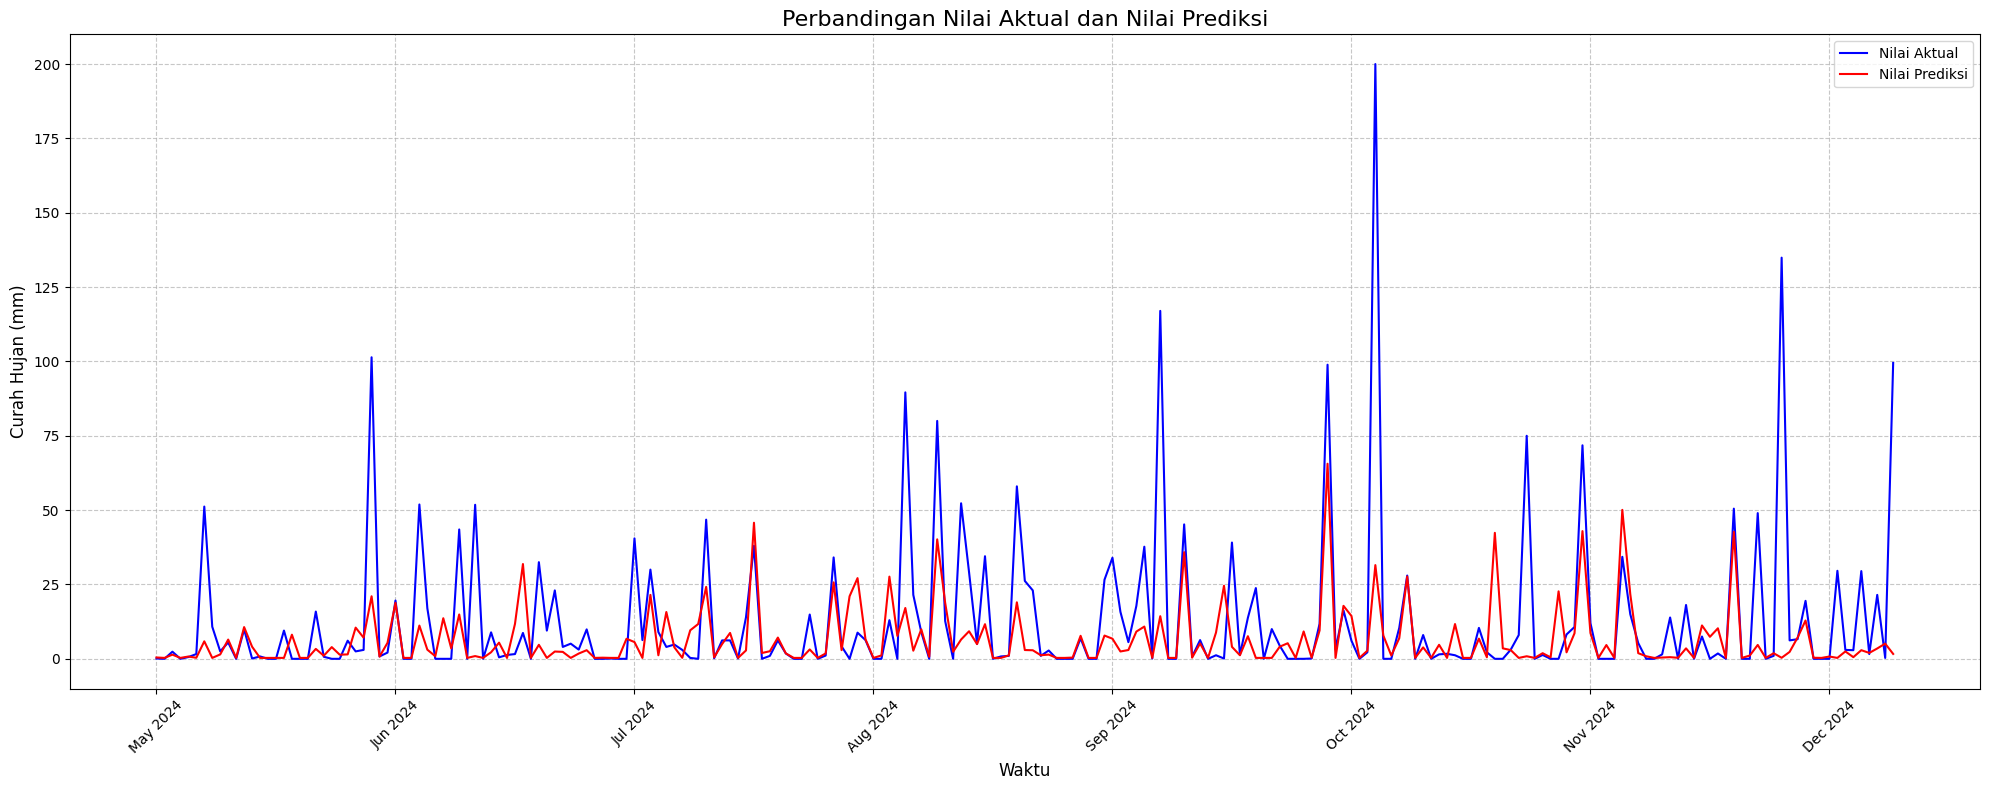

MAE for Best ELM model: 10.402544343499422
MSE for Best ELM model: 509.4607231650066


In [11]:
# Plot the actual vs predicted rainfall for the best ELM model (using MAE)
plt.figure(figsize=(20, 8))

# Plot actual data (blue)
plt.plot(y_test, color='blue', label='Nilai Aktual')

# Plot predictions (red) for the best ELM model
plt.plot(best_predictions, color='red', label='Nilai Prediksi')


# Adding title and labels
plt.title('Perbandingan Nilai Aktual dan Nilai Prediksi', fontsize=16)
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Curah Hujan (mm)', fontsize=12)

# Adding Year-Month labels on the X-axis (every 6 months)
dates = data['Tanggal'].iloc[-len(y_test):]  # Ambil tanggal sesuai jumlah data uji
years_months = dates.dt.strftime('%b %Y')  # Format bulan dan tahun

# Display each label per 6 data (to reduce density)
plt.xticks(ticks=np.arange(0, len(dates), step=30), labels=years_months[::30], rotation=45, fontsize=10)

# Adding legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Print the performance metrics (MAE, MSE)
print(f"MAE for Best ELM model: {best_mae}")
print(f"MSE for Best ELM model: {best_mse}")

Text(0.5, 1.0, 'Perbandingan MAE untuk Jumlah Neuron yang Berbeda')

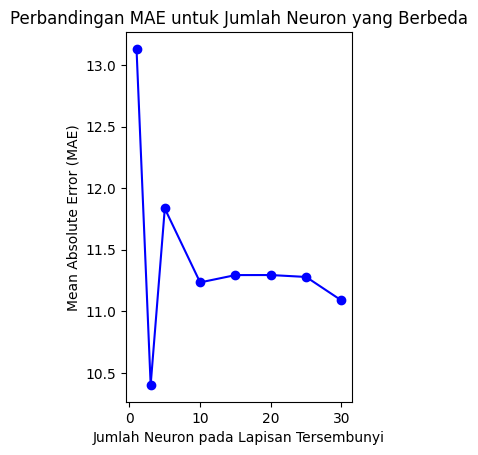

In [12]:
# Grafik MAE
plt.subplot(1, 2, 1)
plt.plot(hidden_sizes, mae_scores_for_hidden_sizes, marker='o', color='blue')
plt.xlabel('Jumlah Neuron pada Lapisan Tersembunyi')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Perbandingan MAE untuk Jumlah Neuron yang Berbeda')

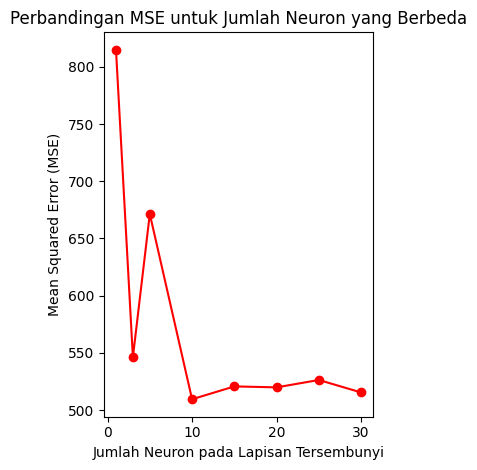

In [13]:
# Grafik MSE
plt.subplot(1, 2, 2)
plt.plot(hidden_sizes, mse_scores_for_hidden_sizes, marker='o', color='red')
plt.xlabel('Jumlah Neuron pada Lapisan Tersembunyi')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Perbandingan MSE untuk Jumlah Neuron yang Berbeda')

plt.tight_layout()
plt.show()

In [14]:
# 18. Fitting distribusi GEV pada data ekstrem
monthly_extremes = bulan_max['Curah Hujan'].values

params = stats.genextreme.fit(monthly_extremes)  # Fitting distribusi GEV dengan data ekstrem
shape, loc, scale = params  # Parameter distribusi GEV: shape, location, scale

# 19. Menampilkan parameter distribusi GEV
print(f"GEV Parameters - Shape: {shape}, Location: {loc}, Scale: {scale}")

# 20. Menguji kesesuaian distribusi GEV dengan uji Kolmogorov-Smirnov
ks_stat, ks_p_value = stats.kstest(monthly_extremes, 'genextreme', args=params)

# 21. Menampilkan hasil uji kesesuaian
print(f"Kolmogorov-Smirnov Test Statistic: {ks_stat}, P-value: {ks_p_value}")

GEV Parameters - Shape: -0.22660133886763678, Location: 44.09985734977555, Scale: 28.761893110233643
Kolmogorov-Smirnov Test Statistic: 0.10481139897611547, P-value: 0.7855973633676122


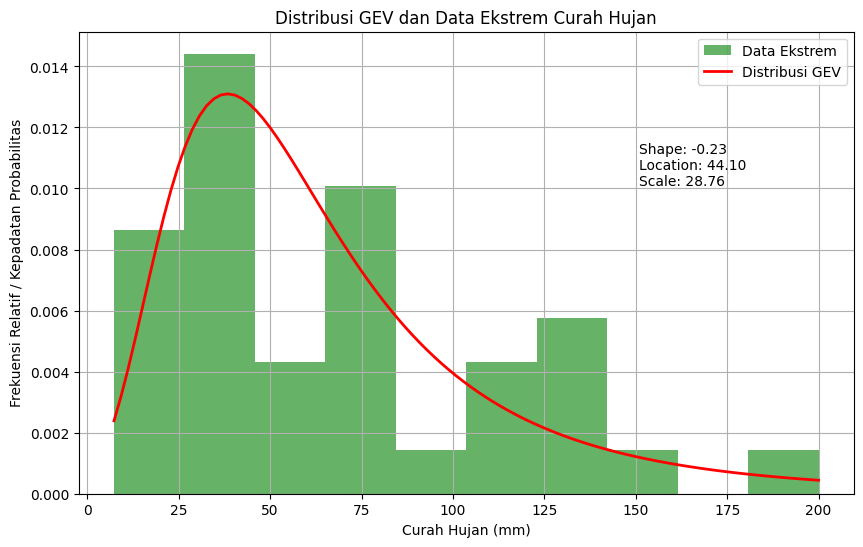

In [15]:
# 22. Plot histogram data ekstrem dan distribusi GEV
plt.figure(figsize=(10, 6))

# 23. Histogram data ekstrem
plt.hist(monthly_extremes, bins=10, density=True, alpha=0.6, color='g', label='Data Ekstrem')

# 24. Menghitung PDF dari distribusi GEV
x = np.linspace(min(monthly_extremes), max(monthly_extremes), 100)
pdf_gev = stats.genextreme.pdf(x, *params)

# 25. Plot distribusi GEV
plt.plot(x, pdf_gev, 'r-', lw=2, label='Distribusi GEV')

# 26. Menambahkan label dan judul
plt.title('Distribusi GEV dan Data Ekstrem Curah Hujan')
plt.xlabel('Curah Hujan (mm)')
plt.ylabel('Frekuensi Relatif / Kepadatan Probabilitas')
plt.text(151, 0.0101, f'Shape: {shape:.2f}\nLocation: {loc:.2f}\nScale: {scale:.2f}', fontsize=10)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# 27. Fungsi untuk menghitung Value at Risk (VaR)
def calculate_var(p, shape, loc, scale):
    # Menghitung VaR dengan rumus GEV
    var = loc + scale * ((-np.log(1 - p)) ** shape - 1) / shape
    return var

# 28. Tingkat kepercayaan yang ingin dihitung VaR-nya (90%, 95%, 99%)
confidence_levels = [0.90, 0.95, 0.99]

In [17]:
# 29. Menghitung VaR untuk masing-masing tingkat kepercayaan
var_values_gev = []
for p in confidence_levels:
    # Menghitung VaR pada tingkat kepercayaan p dengan distribusi GEV
    var_gev = calculate_var(p, shape, loc, scale)
    var_values_gev.append(var_gev)
    print(f"VaR pada {int(p*100)}% kepercayaan dengan GEV: {var_gev}")

VaR pada 90% kepercayaan dengan GEV: 65.95769951850633
VaR pada 95% kepercayaan dengan GEV: 72.04000349827805
VaR pada 99% kepercayaan dengan GEV: 81.22997687716374


In [18]:
# 30. Fungsi untuk menghitung residual life (rata-rata data yang melebihi threshold)
def calculate_residual_life(threshold, data):
    # Ambil data yang lebih besar dari threshold
    exceedances = data[data > threshold]
    
    # Jika ada data yang melebihi threshold, hitung rata-rata residual life
    if len(exceedances) > 0:
        residual_life = np.mean(exceedances - threshold)
    else:
        residual_life = np.nan  # Jika tidak ada data yang melebihi threshold
    
    return residual_life

In [19]:
# 31. Tentukan rentang threshold yang ingin diuji
thresholds = np.linspace(min(monthly_extremes), max(monthly_extremes), 100)
residual_life_values = []

# 32. Hitung residual life untuk setiap threshold
for threshold in thresholds:
    residual_life_values.append(calculate_residual_life(threshold, monthly_extremes))

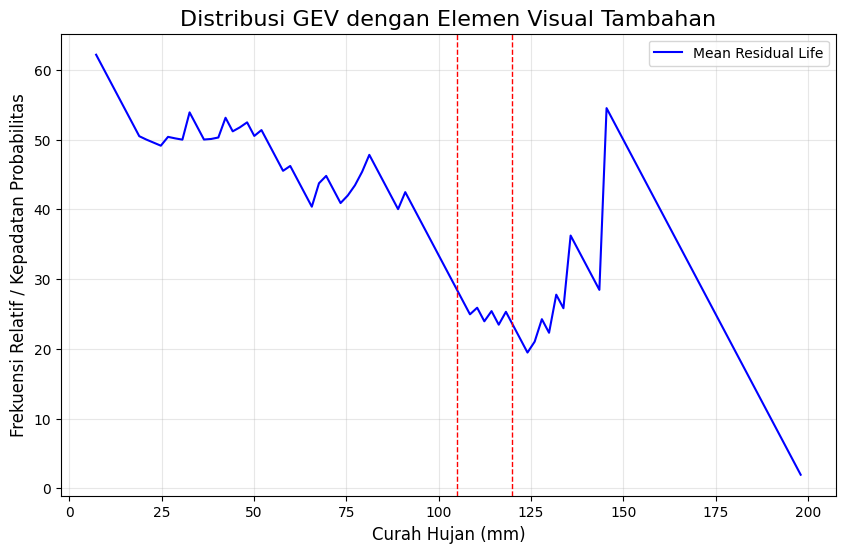

In [20]:
# 33. Plot MRLP
plt.figure(figsize=(10, 6))
plt.plot(thresholds, residual_life_values, label="Mean Residual Life", color='blue')

# 34. PDF distribusi GEV
x = np.linspace(min(monthly_extremes), max(monthly_extremes), 500)
pdf_gev = genextreme.pdf(x, *params)

# 35. Confidence interval
lower_bound = pdf_gev - 0.005
upper_bound = pdf_gev + 0.005

# 36. Garis vertikal threshold
thresholds = [105, 120]
for threshold in thresholds:
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=1)

# 37. Menambahkan label dan judul
plt.title('Distribusi GEV dengan Elemen Visual Tambahan', fontsize=16)
plt.xlabel('Curah Hujan (mm)', fontsize=12)
plt.ylabel('Frekuensi Relatif / Kepadatan Probabilitas', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [21]:
# 38. Threshold yang sudah ditentukan (110 mm)
threshold = 110

# 39. Identifikasi nilai ekstrem yang lebih besar dari threshold
extreme_values = monthly_extremes[monthly_extremes > threshold]

# 40. Menampilkan nilai ekstrem yang teridentifikasi
print(f"Jumlah nilai ekstrem (lebih besar dari threshold {threshold} mm): {len(extreme_values)}")

Jumlah nilai ekstrem (lebih besar dari threshold 110 mm): 9


In [22]:
# 41. Fitting distribusi Generalized Pareto Distribution (GPD) pada nilai ekstrem
params_gpd = stats.genpareto.fit(extreme_values)  # Fitting distribusi GPD pada data ekstrem
shape_gpd, loc_gpd, scale_gpd = params_gpd  # Parameter distribusi GPD: shape, location, scale

# 42. Menampilkan parameter distribusi GPD
print(f"GPD Parameters - Shape: {shape_gpd}, Location: {loc_gpd}, Scale: {scale_gpd}") 

GPD Parameters - Shape: -1.4640967792431479, Location: -0.5822688549652044, Scale: 293.67185380383773


In [23]:
# 43. Plot distribusi GPD pada nilai ekstrem
x_gpd = np.linspace(min(extreme_values), max(extreme_values), 100)
pdf_gpd = stats.genpareto.pdf(x_gpd, *params_gpd)

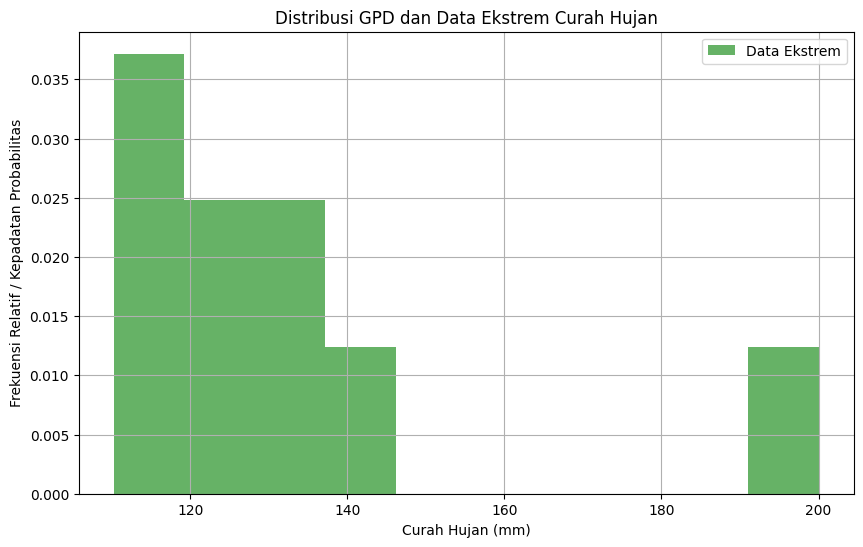

In [24]:
# 44. Plot histogram data ekstrem dan distribusi GPD
plt.figure(figsize=(10, 6))

# 45. Histogram data ekstrem (gunakan extreme_values, bukan monthly_extremes)
plt.hist(extreme_values, bins=10, density=True, alpha=0.6, color='g', label='Data Ekstrem')

# 46. Menambahkan label dan judul
plt.title('Distribusi GPD dan Data Ekstrem Curah Hujan')
plt.xlabel('Curah Hujan (mm)')
plt.ylabel('Frekuensi Relatif / Kepadatan Probabilitas')

plt.legend()
plt.grid(True)
plt.show()

In [25]:
# 47. Menghitung VaR untuk masing-masing tingkat kepercayaan
var_values = {}
for p in confidence_levels:
    var = calculate_var(p, shape_gpd, loc_gpd, scale_gpd)
    var_values[p] = var

# 48. Output hasil VaR
print("\nHasil VaR:")
for p, var in var_values.items():
    print(f"Tingkat Kepercayaan {int(p*100)}%: {var:.4f}")


Hasil VaR:
Tingkat Kepercayaan 90%: 140.8474
Tingkat Kepercayaan 95%: 159.7611
Tingkat Kepercayaan 99%: 178.5594
